In [3]:
!pip install datasets
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00a 0:00:01


In [5]:
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset
import pandas as pd
import torch
import numpy as np

In [6]:
dataset= load_dataset('gopalkalpande/bbc-news-summary', split='train')
data=dataset.train_test_split(test_size=0.2, shuffle=True)
train_data=data['train']
test_data=data['test']
train_df=pd.DataFrame(train_data)
test_df=pd.DataFrame(test_data)
print(train_df['File_path'].unique())
train_df.head()

Generating train split:   0%|          | 0/2224 [00:00<?, ? examples/s]

['tech' 'politics' 'sport' 'entertainment' 'business']


,File_path,Articles,Summaries
0,tech,Text message record smashed..UK mobile owners ...,"Before December's bumper text record, the prev..."
1,tech,Microsoft debuts security tools..Microsoft is ...,Microsoft is releasing tools that clean up PCs...
2,politics,Muslims discuss election concerns..Issues that...,"""This meeting is not anti-party in particular,..."
3,sport,Reyes tricked into Real admission..Jose Antoni...,"""I'm happy Madrid is interested in me because ..."
4,sport,Robinson answers critics..England captain Jaso...,"Robinson said: ""We are certainly not on the de..."


In [7]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
def preprocess_function(examples):
    inputs = [f"summarize: {article}" for article in examples['Articles']]
    model_inputs = tokenizer(
        inputs,
        max_length=512,
        truncation=True,
        padding='max_length'
    )

    # Set up the tokenizer for targets
    targets = [summary for summary in examples['Summaries']]
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=512,
            truncation=True,
            padding='max_length'
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


tokenized_train = train_data.map(
    preprocess_function,
    batched=True,
    num_proc=4
)
tokenized_valid = test_data.map(
    preprocess_function,
    batched=True,
    num_proc=4
)


/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/1779 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will l

Map (num_proc=4):   0%|          | 0/445 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('t5-small')
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model

In [ ]:
!pip install rouge_score
!pip install accelerate
! pip install -U accelerate
! pip install -U transformers

In [ ]:
import evaluate
import accelerate
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred.predictions[0], eval_pred.label_ids

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True,
        rouge_types=[
            'rouge1',
            'rouge2',
            'rougeL'
        ]
    )

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}
def preprocess_logits_for_metrics(logits, labels):
    pred_ids = torch.argmax(logits[0], dim=-1)
    return pred_ids, labels

In [ ]:
training_args = TrainingArguments(
output_dir='./kaggle/working/summary_model',
    num_train_epochs=5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./kaggle/working/summary_model',
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=200,
    save_strategy='epoch',
    save_total_limit=2,
    learning_rate=0.0001,
)
trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_metrics=compute_metrics,

)
trainer.train()

In [ ]:
tokenizer.save_pretrained('summary_model')
model_path = 'summary_model/checkpoint-1780'  # Assuming the checkpoint directory
model = T5ForConditionalGeneration.from_pretrained(model_path)  # Don't use from_pretrained

In [ ]:
text = test_data['Articles'][13]



inputs = tokenizer(text, truncation=True, padding="max_length", return_tensors="pt") 
with torch.no_grad():  
  outputs = model.generate(**inputs)  

summary_ids = outputs[0]  # Access the generated summary token ids
summary_text = tokenizer.decode(summary_ids, skip_special_tokens=True)  

print("Summary:", summary_text)

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer.batch_encode_plus(train_data['Articles'], padding=True, truncation=True, return_tensors='pt')
val_encodings = tokenizer.batch_encode_plus(test_data['Articles'], padding=True, truncation=True, return_tensors='pt')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [41]:
from sklearn.preprocessing import LabelEncoder
class_column = 'File_path'

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the class labels
train_df[class_column + '_encoded'] = label_encoder.fit_transform(train_data[class_column])
test_df[class_column + '_encoded'] = label_encoder.fit_transform(test_data[class_column])
train_d=TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_df['File_path_encoded']))
test_d=TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(test_df['File_path_encoded']))

train_loader=DataLoader(train_d, batch_size=12, shuffle=True)
test_loader=DataLoader(test_d, batch_size=12, shuffle=False)
# train_df.head()
classes={ train_df[train_df['File_path']==a]['File_path_encoded'].iloc[0] : a for a in list(train_df['File_path'].unique())}
print(classes)

{4: 'tech', 2: 'politics', 3: 'sport', 1: 'entertainment', 0: 'business'}


In [15]:
num_classes = 5

# Initialize the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

# Move the model to the GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
import optuna
import torch.nn as nn

In [17]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    for batch in train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(input_ids, attention_mask=attention_mask).logits
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()  # Call optimizer step after backward pass
        

def evaluate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
         for batch in test_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, predicted_labels = torch.max(logits, 1)
            labels = labels.long()
            loss = criterion(logits, labels)
            val_loss += loss.item() * input_ids.size(0)
            correct += (predicted_labels == labels).sum().item()
    val_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return val_loss, accuracy

In [18]:
def objective(trial):#tuning with bayesian
    learning_rate = trial.suggest_loguniform('learning_rate', 5e-7, 5e-5)

    # Model, criterion, optimizer
    num_classes = 5

    # Initialize the BERT model
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

    # Move the model to the GPU (if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    batch_size=trial.suggest_int('batch_size', 12,16)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-2)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_loader=DataLoader(train_d, batch_size=12, shuffle=True)
    test_loader=DataLoader(test_d, batch_size=12, shuffle=False)
    # Training loop
    epochs = 2
    for epoch in range(epochs):
        train(model, device, train_loader, optimizer, criterion)
        val_loss, accuracy = evaluate(model, device, test_loader, criterion)

    return val_loss  # Optuna minimizes the objective value

In [19]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=4)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_trial.params)

[I 2024-06-05 17:43:55,309] A new study created in memory with name: no-name-ecbd091a-09f9-4633-873a-5fca80c10ee5
/tmp/ipykernel_34/96783110.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 5e-7, 5e-5)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_34/96783110.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('w

Best hyperparameters:  {'learning_rate': 2.2370614138488478e-05, 'batch_size': 16, 'weight_decay': 0.0012012600708599407}


In [20]:
best_params=study.best_trial.params
# best_params
num_classes = 5

# Initialize the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
PATH = 'classify_model.pth'
# Define the criterion and optimizer
best_val_loss=np.Inf
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
train_loader=DataLoader(train_d, batch_size=best_params['batch_size'], shuffle=True)
test_loader=DataLoader(test_d, batch_size=best_params['batch_size'], shuffle=False)
# Train the model
for epoch in range(5):
    train(model, device, train_loader, optimizer, criterion)
    val_loss, val_accuracy = evaluate(model, device, test_loader, criterion)
    if val_loss<best_val_loss:
      best_val_loss=val_loss
      torch.save(model.state_dict(), PATH)
      print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1070, Validation Accuracy: 0.9843
Validation Loss: 0.0708, Validation Accuracy: 0.9888
Validation Loss: 0.0631, Validation Accuracy: 0.9888


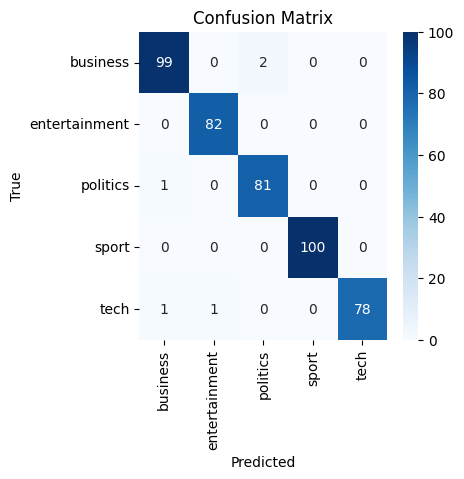

In [42]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model.load_state_dict(torch.load(PATH))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).flatten()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Construct the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

cl=[]
for i in range(num_classes):
    cl.append(classes[i])
# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cl, yticklabels=cl)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
